In [40]:
import numpy as np 
import math 
import torch
import torch.optim as optim
from torch.distributions import Normal
from torch.nn.functional import relu
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
T = 50          # assuming there are T period left.
gamma = 0.97    # discount factor.

In [41]:
class TwoEchelonInv:
    """
    the setup of two-echelon inventory model.
    """
    def __init__(self, 
                 h1 = 1.0,     # marginal holding cost for installation 1.
                 p1 = 10.0,    # marginal shortage cost for installation 1.
                 h2 = 1.0,     # marginal holding cost for installation 2.
                 demand_lambda = 5,     # suppose the demand follows possion distribution, \lambda = 5.
                 
                 # initial state variables.    
                 init_x1 = 20.0,     # initial stock on hand for installation 1.
                 init_w1 = 0.0,      # initial stock in transit.
                 init_x2 = 40.0,     # initial system stock. 
                 init_w2 = 0.0,
                 K = 0.0,            # purchase setup one time cost.
                 c = 1.0,            # purchase per unit cost.
                 c1 = 1.0,           # transit cost per unit within installations.
                 seed = None         # add stochasticity.  
                 ):

        self.h1 = h1 
        self.p1 = p1
        self.h2 = h2 
        self.demand_lambda = demand_lambda
        self.init_x1 = init_x1
        self.init_w1 = init_w1
        self.init_x2 = init_x2
        self.init_w2 = init_w2
        self.K = K 
        self.c = c
        self.c1 = c1
        
        if seed is not None:
            np.random.seed(seed)
        self.reset()

        # current state variables.
        self.x1 = init_x1 
        self.w1 = init_w1
        self.x2 = init_x2
        self.w2 = init_w2
        self.t = 0     # tracking the current time step. 

    def reset(self) -> np.ndarray:
        """
        reset the model to initial state, to be used in monte carlo simulation.

        Return: a 3 dimension array containing state variables(np.ndarray)  
        """
        self.x1 = self.init_x1
        self.w1 = self.init_w1
        self.x2 = self.init_x2
        self.w2 = self.init_w2
        self.t = 0

        return np.array([self.x1, self.w1, self.x2, self.w2], dtype=np.float32)

    
    def purchase_cost(self, z: float) -> float:
        """
        compute the purchase cost

        Args:
        z (float): purchase quantity.

        Return:
        float: if z > 0, return setup cost + per unit cost, else no cost.
        """
        return self.K + self.c * z if z > 0 else 0.0
    
    def shortage_storage_cost(self, x: float) -> float:
        """
        compute the shortage and storage cost.

        Args:
        x (float): current order level at installation 1 after the demand is taken (can be positive and negitive).

        Return:
        float: the shortage and storage cost.
        """
        return self.h1 * x if x >= 0 else self.p1 * (-x)

    def next_step(self, a1: float, a2: float) -> Tuple[np.ndarray, float, bool]:
        """
        calculate the total cost of current time step, and update the new state variables.

        Args:
        a1: order request of installation 1 to be delivered at the beginning of next period.
        a2: order request of installation 2 to be delivered at the beginning of next period.

        Return:
        new states variables and the current step cost.
        """
        # 
        demand = demand_lambda
        
        x2_local = self.x2 - self.w1 - self.x1 + self.w2
        
        self.x1 = self.x1 + self.w1 - demand
        self.w1 = min(a1, x2_local)
        cost_w1 = self.c1 * self.w1
        cost_x1 = self.shortage_storage_cost(self.x1)
        
        x2_local = self.x2 - self.w1 - self.x1
        self.x2 = self.x2 + self.w2 - demand
        x2_local = x2_local - self.w1
        self.w2 = a2
        cost_w2 = self.c1 * self.w2
        cost_x2 = max(self.h2 * x2_local, 0)
        
        total_period_cost = cost_x1 + cost_x2 + cost_w1 + cost_w2

        next_state = np.array([self.x1, self.w1, self.x2, self.w2], dtype=np.float32)         

        return (next_state, total_period_cost)


## Continuous Implementation

In [ ]:
# initialization of variables.
h1 = 2.0
p1 = 5.0 
h2 = 1.0
demand_lambda = 5
init_x1 = 10.0 
init_w1 = 0.0 
init_x2 = 20.0
K = 0.0 
c = 1.0 
c1 = 1.0

# assuming base stock policy.
theta1 = torch.tensor(15.0, requires_grad=True)
theta2 = torch.tensor(25.0, requires_grad=True)
params = [theta1, theta2]
optimizer = optim.Adam(params, lr=0.024)     # TODO: test Adam here, try other optimizers later

# gaussion noise params
sigma1 = torch.tensor(0.6)
sigma2 = torch.tensor(0.6)

hist = {
'θ1': [], 'θ2': []}

# apply the policy gradient theorem, monte carlo sampling times = 1000.
num_episodes = 30000      

In [47]:
for epi in range(num_episodes):
    inv = TwoEchelonInv(h1=h1, p1=p1, h2=h2, demand_lambda=demand_lambda, 
                                           init_x1=init_x1, init_w1=init_w1, init_x2=init_x2,
                                           K=K, c=c, c1=c1)
    state = inv.reset()
    rewards = []
    log_probs = []

    # assuming there are T period left. 
    for t in range(T):
        x1, w1, x2, w2 = [torch.tensor(s, dtype=torch.float32, requires_grad=False) for s in state]

        mu1 = relu(theta1 - x1 - w1)
        dist1 = Normal(mu1, sigma1)
        a1 = dist1.sample()
        logp1 = dist1.log_prob(a1)


        mu2 = relu(theta2 - x2 - w2)
        dist2 = Normal(mu2, sigma2)
        a2 = dist2.sample()
        logp2 = dist2.log_prob(a2)

        new_state, cost = inv.next_step(a1.item(), a2.item())


        log_probs.append(logp1 + logp2)

        rewards.append(-cost)

        state = new_state

    G = 0
    # reverse the reward list to calc the action value easier.
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # final loss function in policy gradient theorem.
    terms = [(- logp * G_t) for logp, G_t in zip(log_probs, returns)]
    policy_loss = torch.stack(terms).sum()

    # clear the previous gradient data.
    optimizer.zero_grad()
    # calc the gradient. 
    policy_loss.backward()

    optimizer.step()
    with torch.no_grad():
        hist['θ1'].append(theta1.item())
        hist['θ2'].append(theta2.item())
    if epi % 100 == 0:
        print(f"[{epi:4d}] loss={policy_loss.item():.3f}  θ1={theta1.item():.2f}  θ2={theta2.item():.2f}")

[   0] loss=4.971  θ1=10.17  θ2=16.51
[ 100] loss=3.190  θ1=10.39  θ2=16.47
[ 200] loss=-1.033  θ1=10.40  θ2=16.21
[ 300] loss=-7.174  θ1=10.59  θ2=16.31
[ 400] loss=-10.604  θ1=10.14  θ2=15.81
[ 500] loss=6.021  θ1=10.64  θ2=15.54
[ 600] loss=-11.894  θ1=11.07  θ2=15.31
[ 700] loss=-12.168  θ1=10.64  θ2=15.53
[ 800] loss=4.599  θ1=10.77  θ2=15.59
[ 900] loss=1.835  θ1=11.15  θ2=15.81
[1000] loss=-3.390  θ1=11.33  θ2=16.04
[1100] loss=4.773  θ1=11.20  θ2=15.76
[1200] loss=3.112  θ1=11.55  θ2=15.65
[1300] loss=-8.258  θ1=11.33  θ2=15.81
[1400] loss=-7.722  θ1=11.03  θ2=15.62
[1500] loss=-13.786  θ1=10.83  θ2=15.45
[1600] loss=10.451  θ1=10.82  θ2=15.29
[1700] loss=1.056  θ1=10.96  θ2=15.59
[1800] loss=2.653  θ1=11.10  θ2=15.66
[1900] loss=0.409  θ1=11.55  θ2=15.57
[2000] loss=3.355  θ1=11.22  θ2=15.36
[2100] loss=-10.694  θ1=11.54  θ2=15.49
[2200] loss=-10.608  θ1=11.58  θ2=15.53
[2300] loss=-9.839  θ1=11.73  θ2=15.69
[2400] loss=-5.880  θ1=11.50  θ2=15.55
[2500] loss=-0.561  θ1=11.34  

[21000] loss=-6.478  θ1=10.06  θ2=16.07
[21100] loss=6.655  θ1=9.88  θ2=16.08
[21200] loss=8.883  θ1=10.00  θ2=16.40
[21300] loss=5.400  θ1=10.05  θ2=16.62
[21400] loss=4.628  θ1=10.34  θ2=16.64
[21500] loss=5.152  θ1=10.23  θ2=16.77
[21600] loss=6.218  θ1=10.58  θ2=16.77
[21700] loss=13.589  θ1=10.51  θ2=16.28
[21800] loss=4.060  θ1=10.16  θ2=16.49
[21900] loss=-3.255  θ1=10.15  θ2=16.52
[22000] loss=-2.024  θ1=10.16  θ2=16.54
[22100] loss=2.010  θ1=10.10  θ2=16.39
[22200] loss=1.915  θ1=10.18  θ2=16.34
[22300] loss=-4.632  θ1=10.30  θ2=16.14
[22400] loss=-8.907  θ1=10.56  θ2=15.99
[22500] loss=-13.653  θ1=10.62  θ2=15.73
[22600] loss=17.377  θ1=10.74  θ2=15.56
[22700] loss=-0.289  θ1=11.18  θ2=15.31
[22800] loss=-5.513  θ1=11.22  θ2=15.40
[22900] loss=-19.513  θ1=11.28  θ2=15.24
[23000] loss=-2.197  θ1=11.63  θ2=15.17
[23100] loss=4.462  θ1=11.43  θ2=15.30
[23200] loss=4.206  θ1=11.65  θ2=15.27
[23300] loss=2.039  θ1=11.48  θ2=15.44
[23400] loss=-0.607  θ1=11.23  θ2=15.32
[23500] los

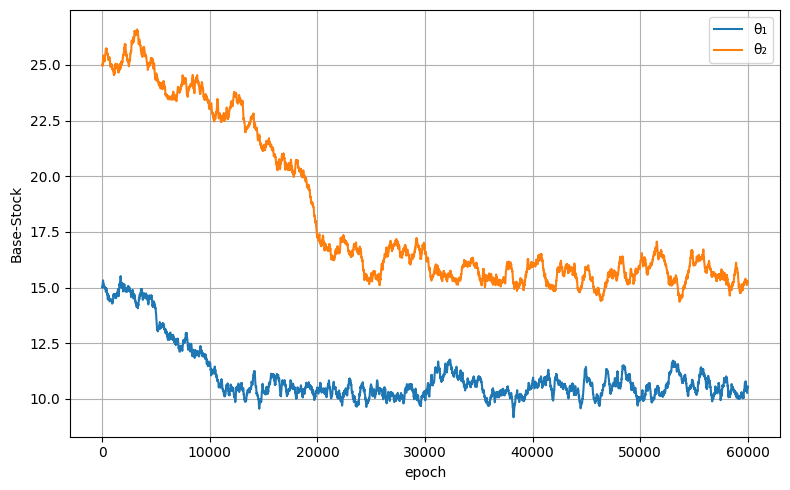

In [48]:
plt.figure(figsize=(8,5))
epochs = range(1, len(hist['θ1'])+1)
plt.plot(epochs, hist['θ1'], label='θ₁')
plt.plot(epochs, hist['θ2'], label='θ₂')

plt.xlabel('epoch')
plt.ylabel('Base‑Stock')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
if __name__ == "__main__":
    # initialization of variables.
    h1 = 2.0
    p1 = 5.0 
    h2 = 1.0
    demand_lambda = 5
    init_x1 = 10.0 
    init_w1 = 0.0 
    init_x2 = 20.0
    K = 0.0 
    c = 1.0 
    c1 = 1.0

    # assuming base stock policy.
    theta1 = torch.tensor(15.0, requires_grad=True)
    theta2 = torch.tensor(25.0, requires_grad=True)
    params = [theta1, theta2]
    optimizer = optim.Adam(params, lr=0.024)     # TODO: test Adam here, try other optimizers later

    # gaussion noise params
    sigma1 = torch.tensor(0.6)
    sigma2 = torch.tensor(0.6)
    
    
    
    hist = {
    'θ1': [], 'θ2': []}


    # apply the policy gradient theorem, monte carlo sampling times = 1000.
    num_episodes = 30000      
    for epi in range(num_episodes):
        inv = TwoEchelonInv(h1=h1, p1=p1, h2=h2, demand_lambda=demand_lambda, 
                                           init_x1=init_x1, init_w1=init_w1, init_x2=init_x2,
                                           K=K, c=c, c1=c1)
        state = inv.reset()
        rewards = []
        log_probs = []
        
        # assuming there are T period left. 
        for t in range(T):
            x1, w1, x2, w2 = [torch.tensor(s, dtype=torch.float32, requires_grad=False) for s in state]
            
            mu1 = relu(theta1 - x1 - w1)
            dist1 = Normal(mu1, sigma1)
            a1 = dist1.sample()
            logp1 = dist1.log_prob(a1)
            
            
            mu2 = relu(theta2 - x2 - w2)
            dist2 = Normal(mu2, sigma2)
            a2 = dist2.sample()
            logp2 = dist2.log_prob(a2)

            new_state, cost = inv.next_step(a1.item(), a2.item())

                        
            log_probs.append(logp1 + logp2)
            
            rewards.append(-cost)
            
            state = new_state

        G = 0
        # reverse the reward list to calc the action value easier.
        returns = []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # final loss function in policy gradient theorem.
        terms = [(- logp * G_t) for logp, G_t in zip(log_probs, returns)]
        policy_loss = torch.stack(terms).sum()
        
        # clear the previous gradient data.
        optimizer.zero_grad()
        # calc the gradient. 
        policy_loss.backward()

        optimizer.step()
        with torch.no_grad():
            hist['θ1'].append(theta1.item())
            hist['θ2'].append(theta2.item())
        if epi % 100 == 0:
            print(f"[{epi:4d}] loss={policy_loss.item():.3f}  θ1={theta1.item():.2f}  θ2={theta2.item():.2f}")

[   0] loss=-2.837  θ1=15.02  θ2=25.02
[ 100] loss=3.643  θ1=15.19  θ2=25.31
[ 200] loss=-14.400  θ1=15.04  θ2=25.16
[ 300] loss=-10.440  θ1=14.99  θ2=25.62
[ 400] loss=-8.457  θ1=14.85  θ2=25.71
[ 500] loss=2.300  θ1=14.52  θ2=25.45
[ 600] loss=-6.930  θ1=14.61  θ2=25.31
[ 700] loss=-3.087  θ1=14.40  θ2=25.27
[ 800] loss=22.723  θ1=14.43  θ2=24.99
[ 900] loss=-11.345  θ1=14.34  θ2=24.94
[1000] loss=0.574  θ1=14.46  θ2=24.76
[1100] loss=-2.758  θ1=14.62  θ2=24.56
[1200] loss=9.270  θ1=14.57  θ2=24.94
[1300] loss=-8.759  θ1=14.59  θ2=24.85
[1400] loss=-9.157  θ1=14.64  θ2=25.01
[1500] loss=1.587  θ1=14.70  θ2=24.68
[1600] loss=-10.420  θ1=15.16  θ2=24.77
[1700] loss=3.964  θ1=15.51  θ2=24.85
[1800] loss=-12.271  θ1=15.01  θ2=25.03
[1900] loss=-12.410  θ1=15.10  θ2=25.31
[2000] loss=3.172  θ1=15.01  θ2=25.50
[2100] loss=3.716  θ1=14.90  θ2=25.90
[2200] loss=5.548  θ1=14.91  θ2=25.55
[2300] loss=9.413  θ1=14.86  θ2=25.39
[2400] loss=-7.458  θ1=15.01  θ2=25.15
[2500] loss=-2.215  θ1=14.86 

[21000] loss=-9.482  θ1=10.67  θ2=16.71
[21100] loss=-4.997  θ1=10.58  θ2=16.94
[21200] loss=-3.812  θ1=10.30  θ2=16.78
[21300] loss=-5.561  θ1=10.07  θ2=16.30
[21400] loss=3.897  θ1=10.39  θ2=16.31
[21500] loss=2.793  θ1=10.76  θ2=16.28
[21600] loss=4.997  θ1=10.49  θ2=16.35
[21700] loss=7.001  θ1=10.45  θ2=16.72
[21800] loss=2.751  θ1=10.21  θ2=16.69
[21900] loss=-8.742  θ1=10.07  θ2=16.78
[22000] loss=-4.306  θ1=10.36  θ2=16.71
[22100] loss=-1.824  θ1=10.07  θ2=16.66
[22200] loss=-3.695  θ1=10.05  θ2=17.16
[22300] loss=-5.123  θ1=9.74  θ2=17.07
[22400] loss=3.600  θ1=10.20  θ2=17.33
[22500] loss=2.680  θ1=10.32  θ2=17.09
[22600] loss=0.340  θ1=10.34  θ2=17.01
[22700] loss=6.996  θ1=10.25  θ2=17.00
[22800] loss=5.614  θ1=10.39  θ2=16.95
[22900] loss=-8.926  θ1=10.63  θ2=16.67
[23000] loss=-1.413  θ1=10.88  θ2=16.58
[23100] loss=-3.182  θ1=10.69  θ2=16.40
[23200] loss=1.056  θ1=10.27  θ2=16.64
[23300] loss=5.989  θ1=10.02  θ2=16.61
[23400] loss=-12.622  θ1=9.93  θ2=16.95
[23500] loss=

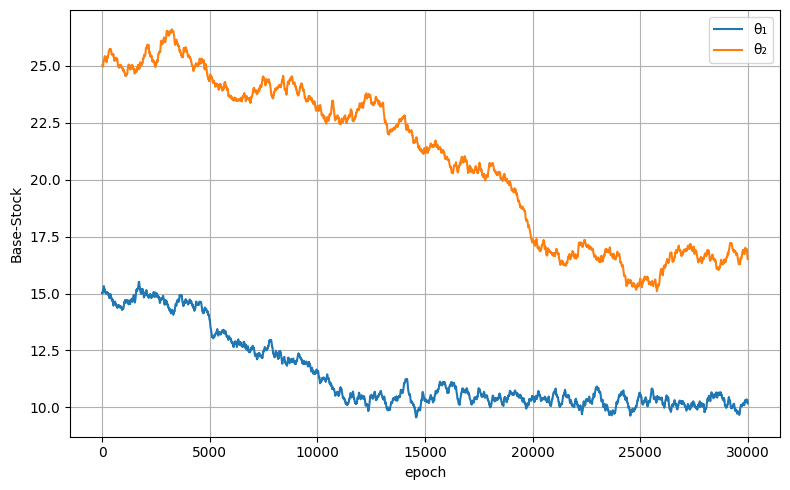

In [43]:
plt.figure(figsize=(8,5))
epochs = range(1, num_episodes+1)
plt.plot(epochs, hist['θ1'], label='θ₁')
plt.plot(epochs, hist['θ2'], label='θ₂')

plt.xlabel('epoch')
plt.ylabel('Base‑Stock')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
inv = TwoEchelonInv(h1=h1, p1=p1, h2=h2, demand_lambda=demand_lambda, 
                                           init_x1=init_x1, init_w1=init_w1, init_x2=init_x2,
                                           K=K, c=c, c1=c1)
state = inv.reset()
print(theta1, theta2)
theta1 = torch.tensor(15.0, requires_grad=True)
theta2 = torch.tensor(25.0, requires_grad=True)
for t in range(4):
            x1, w1, x2, w2 = [torch.tensor(s, dtype=torch.float32, requires_grad=False) for s in state]
            print(x1, w1, x2, w2)
            mu1 = relu(theta1 - x1 - w1)
            dist1 = Normal(mu1, 1.0)
            a1 = dist1.sample()
            logp1 = dist1.log_prob(a1)
            
            
            mu2 = relu(theta2 - x2 - w2)
            dist2 = Normal(mu2, 1.0)
            a2 = dist2.sample()
            logp2 = dist2.log_prob(a2)

            new_state, cost = inv.next_step(a1.item(), a2.item())
            print('demand:', a1, a2)
                        
            log_probs.append(logp1 + logp2)
            
            rewards.append(-cost)
            
            state = new_state
            print('-----------------------')

tensor(15., requires_grad=True) tensor(25., requires_grad=True)
tensor(10.) tensor(0.) tensor(20.) tensor(0.)
demand: tensor(4.4684) tensor(5.3790)
-----------------------
tensor(5.) tensor(4.4684) tensor(15.) tensor(5.3790)
demand: tensor(6.2692) tensor(4.5806)
-----------------------
tensor(4.4684) tensor(6.2692) tensor(15.3790) tensor(4.5806)
demand: tensor(4.2781) tensor(5.8397)
-----------------------
tensor(5.7376) tensor(4.2781) tensor(14.9596) tensor(5.8397)
demand: tensor(4.1300) tensor(3.9594)
-----------------------
